In [1]:
import os
import numpy as np
import pandas as pd
import array
import mmap
import matplotlib.pyplot as plt
import seaborn as sns
sep = '/'

- Load raw data

In [2]:
path = "/Users/sharplab/tran/cat/Tran/2018-05-03_02 (done)/2018-05-03_02.dat"
kilosort_folder = '/Users/sharplab/tran/cat/Tran'
recording = '2018-05-03_02 (done)'
fig_path = "/Users/sharplab/tran/cat/Tran/2018-05-03_02 (done)/figures"
data = np.memmap(path, shape =(327354368,32), dtype = np.int16)


def load_kilosort_arrays(recording):
    spike_clusters = np.load('spike_clusters.npy')
    spike_times = np.load('spike_times.npy')
    cluster_groups = pd.read_csv('cluster_groups.csv', sep='\t')
    try:  # check data quality
        assert np.shape(spike_times.flatten()) == np.shape(spike_clusters)
    except AssertionError:
        AssertionError('Array lengths do not match in recording {}'.format(
            recording))
    return spike_clusters, spike_times, cluster_groups

def load_data(recording, kilosort_folder, verbose, sep):
    if verbose:
        print('\nLoading Data:\t{}\n'.format(recording))
        os.chdir(sep.join([kilosort_folder, recording]))
        spike_clusters, spike_times, cluster_groups = load_kilosort_arrays(
            recording)
    return spike_clusters, spike_times, cluster_groups

def get_good_cluster_numbers(cluster_groups_df):
    good_clusters_df = cluster_groups_df.loc[cluster_groups_df['group'] == 'good', :]
    return good_clusters_df['cluster_id'].values

spike_clusters, spike_times, cluster_groups = load_data(recording=recording,
                                                        kilosort_folder=kilosort_folder,
                                                        verbose=True,
                                                        sep=sep)

good_cluster_numbers = get_good_cluster_numbers(cluster_groups)


Loading Data:	2018-05-03_02 (done)



Parameters for analysis

In [3]:
cluster_to_plot = good_cluster_numbers[1]
num_spikes_for_averaging = 1000
num_channels = 32
num_samples_per_waveform = 60
waveform_window = np.arange(int(-num_samples_per_waveform/2),int(num_samples_per_waveform/2))
fig_to_save = [fig_path,"cluster"+ str(cluster_to_plot)+'png']

Indexing the spikes for analysis

In [4]:
df = pd.DataFrame({'cluster':spike_clusters.flatten(), 'spike_times':spike_times.flatten()})
df = df.loc[df['cluster'].isin(good_cluster_numbers)]
extracted_spikes = df[df['cluster']==cluster_to_plot]['spike_times'][0:num_spikes_for_averaging]

Generating the mean waveform

In [5]:
threeD_matrix = np.zeros((num_spikes_for_averaging, num_samples_per_waveform, num_channels)) # Create the 3D matrix witht he shape (1000,60,32)

for spike in np.arange(0,num_spikes_for_averaging):
    start_index = int(extracted_spikes.iloc[spike]+waveform_window[0])  #  start of waveform in raw data
    end_index = int((extracted_spikes.iloc[spike]+waveform_window[-1])+1)  #  end of waveform in raw data
    
    waveform = data[start_index:end_index, 0:num_channels] #  extract waveform from raw data
    threeD_matrix[spike, :, :] = waveform[:,:]  #  add extracted waveform to 3d matrix

mean_waveform = np.mean(threeD_matrix, axis=0)

Index out the largest waveform

In [6]:
waveform_per_channel_df = pd.DataFrame(mean_waveform)
maxes = waveform_per_channel_df.apply(np.max, axis=0)
lab = maxes.idxmax()

Plot it

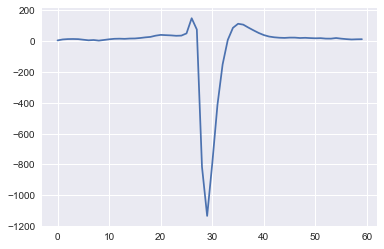

In [7]:
sns.set()
correct_chan = waveform_per_channel_df.loc[:, lab]
correct_chan.plot()
plt.show()

In [8]:
correct_chan = correct_chan.reset_index()
correct_chan.columns = ['figure', 'y_values']
correct_chan.set_index('figure', inplace=True)
new_list = [correct_chan['y_values'][trend_values] for trend_values in np.arange(0,59,1) if (correct_chan['y_values'][trend_values]<correct_chan['y_values'][trend_values+1])]
correct_chan['trend'] = np.where(correct_chan['y_values'].isin(new_list), 'increase', 'decrease')

In [ ]:
def find_return_point(min_peak_time, from_min_to_end, correct_chan):
    return_point = []
    baseline_value = correct_chan.loc[find_baseline(max_peak_time, from_start_to_max, correct_chan)[-1]][0]
    
    '''
    return point is the first value after the trough that is between +- 50% of the baseline values
    '''
    for return_time_point in from_min_to_end:
        if ((baseline_value + baseline_value/2) > np.absolute(correct_chan.loc[return_time_point][0]) > (baseline_value - baseline_value/2)) or ((baseline_value + baseline_value/2) < correct_chan.loc[return_time_point][0] < (baseline_value - baseline_value/2)):
            return_point.append(return_time_point)
        else:
            pass
    return return_point

In [23]:
min_value = correct_chan['y_values'].min()
max_value = correct_chan['y_values'].max()
min_peak_time = correct_chan['y_values'].idxmin()
max_peak_time = correct_chan['y_values'].idxmax()

''' 
Split the data into 3 periods for analysis
1) from start to the max (baseline value is in this period)
2) from max to min (can just index max and min peak time directly)
3) from min to end (return of baseline value is in this period)

In case that there's no min peak, the data is split into
1) from start to max
2) from max to end
'''

from_start_to_max = np.arange(0, max_peak_time, 1)
from_min_to_end = np.arange(min_peak_time, 60, 1) 
counter_when_no_min = np.arange(max_peak_time, 60, 1)

def find_baseline(max_peak_time, from_start_to_max, correct_chan): #Method to find baseline is standardised for all types of waveforms 
    baseline = []
    
    ''' 
    Baseline is defined as the the last value, from start to max period, that is smaller than 10% of peak value 
    '''
    
    for time_point in from_start_to_max:
        if (correct_chan.loc[time_point][0] < (correct_chan.loc[max_peak_time][0]/10)): 
            baseline.append(time_point)
        else:
            pass
    return baseline

def find_return_point(min_peak_time, from_min_to_end, correct_chan):
    return_point = []
    baseline_value = correct_chan.loc[find_baseline(max_peak_time, from_start_to_max, correct_chan)[-1]][0]
    
    '''
    return point is the first value just before the value higher than baseline value
    '''
    for return_time_point in from_min_to_end:
        if correct_chan.loc[return_time_point][0] > baseline_value:
            return return_time_point-1
        else:
            pass

def plot_waveform(fig_to_save, correct_chan, baseline, min_peak_time, baseline_value, return_point):
    plt.plot(correct_chan['y_values'], linestyle=None, marker='.')
    plt.plot(np.ones(5)*baseline, np.linspace(-400, 650, 5), 'k')
    plt.plot(np.ones(5)*min_peak_time, np.linspace(-400, 650, 5), 'k')
    plt.plot(np.ones(5)*return_point, np.linspace(-400, 650, 5), 'k')
    
    
    '''
    Find the estimation of the return to baseline value if the return point is not very accurate due to not having enough data points
    
    y=ax+b
    
    where y is our y value x is time
    
    we can find the values of a and b by solving the simultaneous equation using the x and y values of the two data points above and below:

    y1 = ax1 + b 
    y2 = ax2 + b 

    => a = (x1-x2)/(y1-y2)
   
       b = y1-ax1
    '''
    
    
    a = (correct_chan.loc[return_point][0]-correct_chan.loc[return_point+1][0])/(return_point-(return_point+1))
    b = correct_chan.loc[return_point][0]-a*(return_point)

    estimated_return_time = (baseline_value-b)/a
    plt.plot(np.ones(5)*estimated_return_time, np.linspace(-400, 650, 5), 'r')

    plt.savefig(sep.join(fig_to_save))

def find_return_point_when_no_min(max_peak_time, counter_when_no_min, correct_chan):
    return_point_when_no_min = []
    base_value = correct_chan.loc[find_baseline(max_peak_time, from_start_to_max, correct_chan)[-1]][0]
    
    '''
    Same as the previous method except using the data points from max (instead of min) till the end:
    '''
        
    for no_min_return_point in counter_when_no_min:
        if np.absolute(base_value + base_value/2) > np.absolute(correct_chan.loc[no_min_return_point][0]) > np.absolute(base_value - base_value/2):
            return_point_when_no_min.append(no_min_return_point)
        else:
            pass
    return return_point_when_no_min


def plot_waveform_when_no_min(fig_to_save, baseline, correct_chan, baseline_value, no_min_return_point):
    plt.plot(correct_chan['y_values'], linestyle=None, marker='.')
    plt.plot(np.ones(5)*baseline_value, np.linspace(-400, 650, 5), 'k')
    plt.plot(np.ones(5)*no_min_return_point[0], np.linspace(-400, 650, 5), 'k')
    
    a = (correct_chan.loc[no_min_return_point][0]-correct_chan.loc[no_min_return_point+1][0])/(no_min_return_point-(no_min_return_point+1))
    b = correct_chan.loc[no_min_return_point][0]-a*(no_min_return_point)

    estimated_return_time = (baseline_value-b)/a
    plt.plot(np.ones(5)*estimated_return_time, np.linspace(-400, 650, 5), 'r')
    plt.savefig(sep.join(fig_to_save))


In [24]:
find_return_point(min_peak_time, from_min_to_end, correct_chan)

33

Parameters and functions for waveform analysis

,Amplitude base-max (V),Amplitude min-max (V),Base to max (ms),Base to min (ms),Return to base (ms),spike_category
0,133.631,1282.16,0.433333,0.533333,0.666667,up_down_up


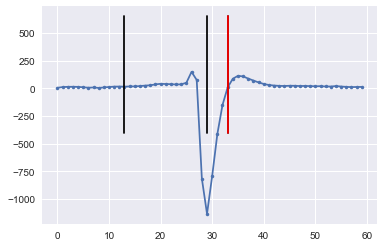

In [27]:
'''
Find the baseline value and its corresponding time point
'''


baseline = find_baseline(max_peak_time, from_start_to_max, correct_chan)[-1]
baseline_value = correct_chan.loc[baseline][0]


'''
3 categories: 1) if there's no max peak (max value <50) or 
                    
                    there's a >50 max, but max occurs after min and min<-50. This is to distinguish with the 2nd category where there's no min peak.
                    
              2) if there's a max value (max > 50) but no min value (min>-50). 
              
              3) normal up-down-up plot
'''

if (max_value-baseline_value<50) or (max_value-baseline_value>50 and max_peak_time>min_peak_time and min_value<-50):
    return_point = find_return_point(min_peak_time, from_min_to_end, correct_chan)[0]
    data_table = pd.DataFrame({'Base to min (ms)':(min_peak_time-baseline)/30, 
                               'Return to base (ms)': (return_point-baseline)/30, 
                               'Amplitude base-min (V)': min_value - baseline_value,
                              'spike_category': 'down_up'},
                              index=[0])
    
    plot_waveform(fig_to_save, correct_chan, baseline, min_peak_time, return_point)

elif (max_value-baseline_value)>50 and (min_value>-50):
    no_min_return_point = find_return_point_when_no_min(max_peak_time, counter_when_no_min, correct_chan)[0]
    data_table = pd.DataFrame({'Base to max (ms)':(max_peak_time-baseline)/30, 
                               'Return to base (ms)': (no_min_return_point-baseline)/30, 
                               'Amplitude base-max (V)':max_value - baseline_value, 
                              'spike_category': 'just_up'}, index=[0])
    
    plot_waveform_when_no_min(fig_to_save, baseline, correct_chan, baseline_value, no_min_return_point)
    
else:
    return_point = find_return_point(min_peak_time, from_min_to_end, correct_chan)
    data_table = pd.DataFrame({'Base to max (ms)':(max_peak_time-baseline)/30, 
                               'Base to min (ms)':(min_peak_time-baseline)/30, 
                               'Return to base (ms)':(return_point-baseline)/30, 
                               'Amplitude base-max (V)':max_value - baseline_value, 
                               'Amplitude min-max (V)':max_value - min_value,
                              'spike_category': 'up_down_up'}, index=[0])
    
    plot_waveform(fig_to_save, correct_chan, baseline, min_peak_time, baseline_value, return_point)
    
data_table
    

In [ ]:
estimated_return_time

In [ ]:
print(baseline_value)
print(correct_chan['y_values'].loc[32])
print(correct_chan['y_values'].loc[33])

## To be use when the first return point is not very accurate due to not having enough data points

Assume the line connecting between the (presumably) return point and the next data point can be expressed by the linear equation:

y=ax+b

where y is our y value
      x is time
      
we can find the values of a and be by solving the simultaneous equation using the x and y values of the two above data points:

y1 = ax1 + b 
y2 = ax2 + b 

=> a = (x1-x2)/(y1-y2)
   
   b = y1-ax1
   
now we can estimate the baseline-return time:

baseline-return time = (baseline-y value -b)/a

In [ ]:
    a = (correct_chan.loc[return_point[0]][0]-correct_chan.loc[return_point[0]+1][0])/(return_point[0]-(return_point[0]+1))
    b = correct_chan.loc[return_point[0]][0]-a*(return_point[0])

    estimated_return_time = (correct_chan.loc[baseline[0]][0]-b)/a

Now plot again

In [ ]:
plt.plot(correct_chan, linestyle=None, marker='.')
plt.plot(np.ones(5)*baseline[0], np.linspace(-400, 650, 5), 'k')
plt.plot(np.ones(5)*min_peak_time, np.linspace(-400, 650, 5), 'k')

#The initial baseline return point
plt.plot(np.ones(5)*return_point[0], np.linspace(-400, 650, 5), 'k')

#new estimated baseline return point shown in red
plt.plot(np.ones(5)*estimated_return_time, np.linspace(-400, 650, 5), 'r')
